# Library & Read Data & Font

In [252]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

plt.rcParams["font.family"] = "serif"

# load dataframe
original_df = pd.read_csv('../data/KaggleV2-May-2016.csv')
original_df.head(10)

original_df.shape

(110527, 14)

In [2]:
original_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
original_df.describe

<bound method NDFrame.describe of            PatientId  AppointmentID Gender          ScheduledDay  \
0       2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1       5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2       4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3       8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4       8.841186e+12        5642494      F  2016-04-29T16:07:23Z   
...              ...            ...    ...                   ...   
110522  2.572134e+12        5651768      F  2016-05-03T09:15:35Z   
110523  3.596266e+12        5650093      F  2016-05-03T07:27:33Z   
110524  1.557663e+13        5630692      F  2016-04-27T16:03:52Z   
110525  9.213493e+13        5630323      F  2016-04-27T15:09:23Z   
110526  3.775115e+14        5629448      F  2016-04-27T13:30:56Z   

              AppointmentDay  Age      Neighbourhood  Scholarship  \
0       2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0   
1       201

# Variable type and missing data

In [4]:
original_df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

array([[<AxesSubplot:title={'center':'PatientId'}>,
        <AxesSubplot:title={'center':'AppointmentID'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Scholarship'}>,
        <AxesSubplot:title={'center':'Hipertension'}>,
        <AxesSubplot:title={'center':'Diabetes'}>],
       [<AxesSubplot:title={'center':'Alcoholism'}>,
        <AxesSubplot:title={'center':'Handcap'}>,
        <AxesSubplot:title={'center':'SMS_received'}>]], dtype=object)

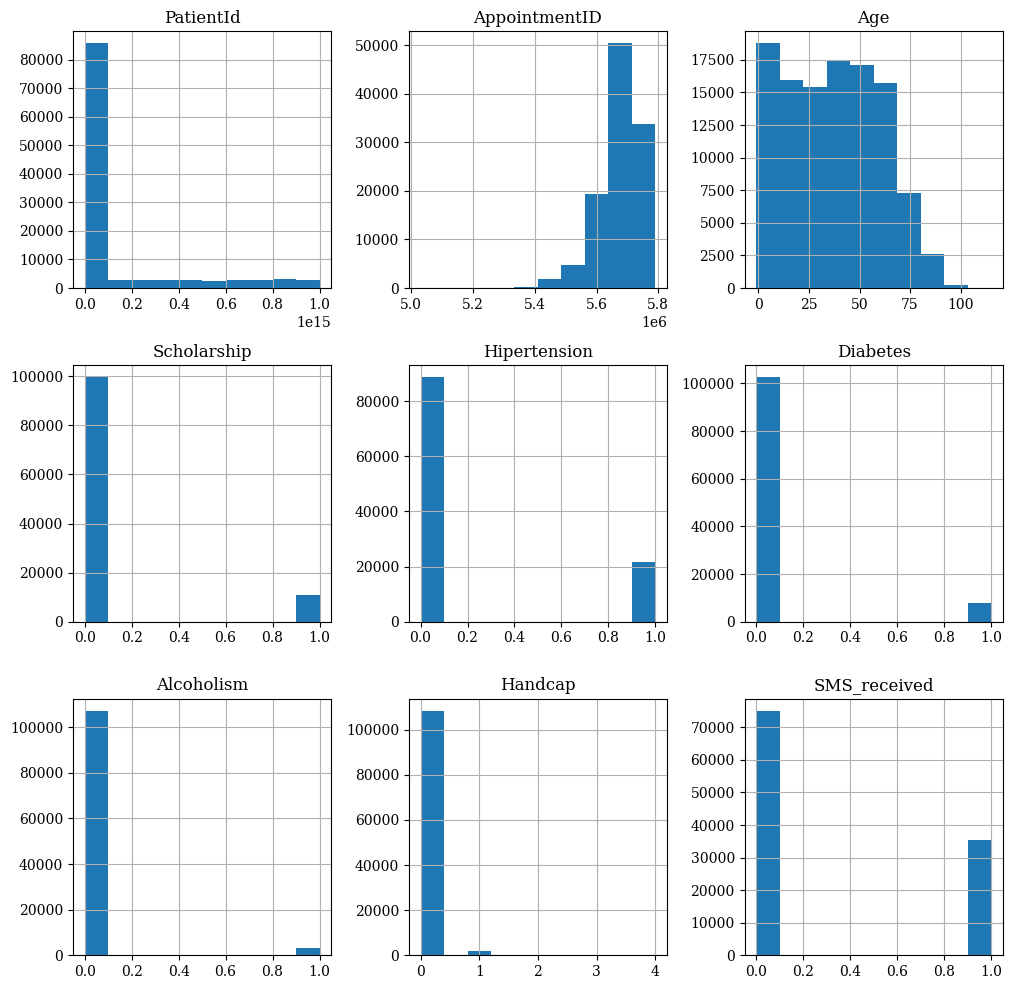

In [5]:
original_df.hist(figsize=(12, 12))

In [6]:
original_df.isna().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

Unique patient

In [7]:
len(original_df['PatientId'])
len(original_df['PatientId'].unique())
sum(original_df['PatientId'].value_counts() >= 2)

24379

AppointmentDate, Saturday, holiday

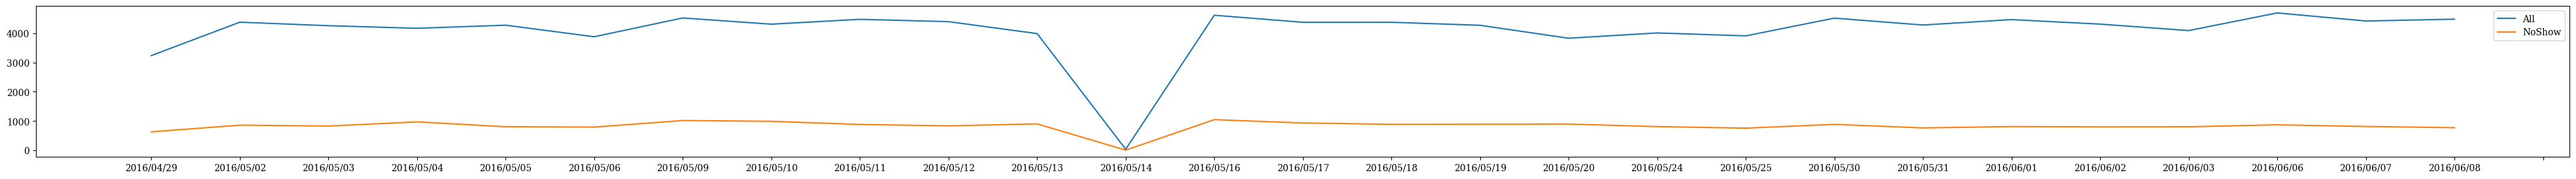

In [8]:
# check AppointmentDate
df_bydate = pd.DataFrame(index=original_df.index)
df_bydate['AppointmentDate'] = pd.to_datetime(original_df['AppointmentDay']).apply(lambda a: '{}/{:02}/{:02}'.format(a.year, a.month, a.day))
df_bydate['NoShow'] = original_df['No-show'].apply(lambda d: 1 if d == 'Yes' else 0)
df_bydate_all_noshow = pd.DataFrame(df_bydate.groupby('AppointmentDate').count())
df_bydate_all_noshow['All'] = df_bydate.groupby('AppointmentDate').count()
df_bydate_all_noshow['NoShow'] = df_bydate.groupby('AppointmentDate').sum()
df_bydate_all_noshow.reset_index(inplace=True)
plt.figure(figsize=(50, 3))
plt.plot(df_bydate_all_noshow['AppointmentDate'], df_bydate_all_noshow['All'], label='All')
plt.plot(df_bydate_all_noshow['AppointmentDate'], df_bydate_all_noshow['NoShow'], label='NoShow')
plt.xticks(np.arange(0, len(df_bydate_all_noshow['AppointmentDate']) + 1, 1))
plt.legend()
plt.show()

In [9]:
# 5/14 Saturday
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/14')&(df_bydate['NoShow']==0)]))
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/14')&(df_bydate['NoShow']==1)]))

30
9


In [10]:
# 5/1 national holiday
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/01')&(df_bydate['NoShow']==0)]))
print(len(df_bydate[(df_bydate['AppointmentDate']=='2016/05/01')&(df_bydate['NoShow']==1)]))

0
0


# EDA

## Target variable

In [12]:
original_df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

Classification type

In [13]:
print(sum(original_df['No-show'] == 'Yes')/original_df.shape[0])
print(sum(original_df['No-show'] == 'No')/original_df.shape[0])

0.20193255946510807
0.798067440534892


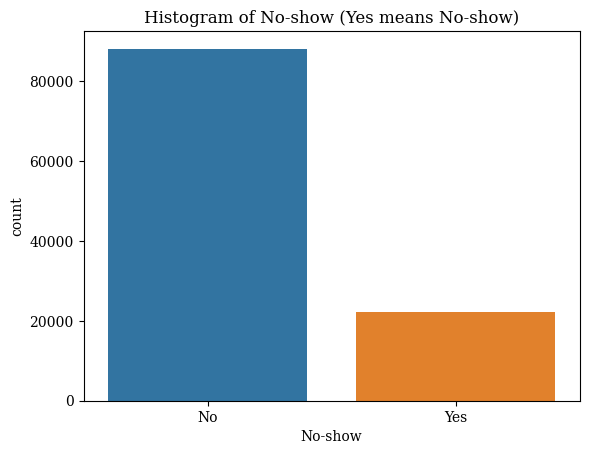

In [14]:
import seaborn
seaborn.countplot(x = original_df['No-show'])
plt.title("Histogram of No-show (Yes means No-show)")
plt.xlabel('No-show')
plt.savefig('No-show.png', dpi=300)

## Features

### SMS_Received

<Figure size 500x300 with 0 Axes>

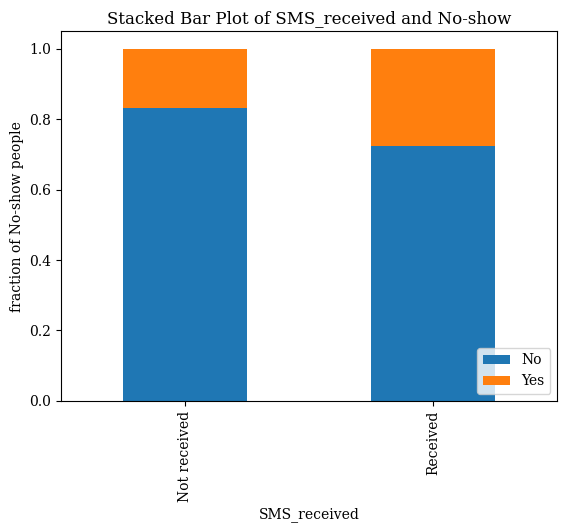

In [15]:
count_matrix = original_df.groupby(['SMS_received', 'No-show']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

plt.figure(figsize=(5,3))
count_matrix_norm.plot(kind='bar', stacked=True)
plt.xticks([0,1], ['Not received', 'Received'])
plt.title("Stacked Bar Plot of SMS_received and No-show")
plt.ylabel('fraction of No-show people')
plt.legend(loc=4)
plt.show()

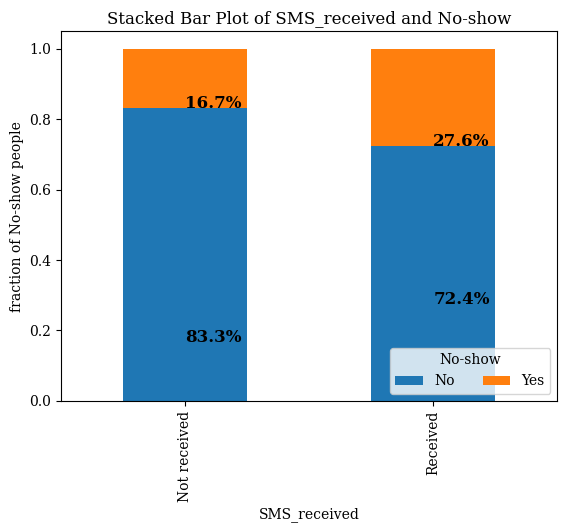

In [16]:
cross_tab_prop = pd.crosstab(index=original_df['SMS_received'],
                             columns=original_df['No-show'],
                             normalize="index")

cross_tab_prop.plot(kind='bar', 
                    stacked=True)

plt.legend(loc="lower right", ncol=2,title='No-show')
plt.xlabel("SMS_received")
plt.ylabel('fraction of No-show people')
plt.xticks([0,1], ['Not received', 'Received'])
plt.title("Stacked Bar Plot of SMS_received and No-show")
for n, x in enumerate([*cross_tab_prop.index.values]):
    for proportion in cross_tab_prop.loc[x]:
                
        plt.text(x=n,
                 y=(1-proportion),
                 s=f'{np.round(proportion * 100, 1)}%', 
                 color="black",
                 fontsize=12,
                 fontweight="bold")
plt.savefig('SMS.png', dpi=300,bbox_inches='tight')
plt.show()

In [17]:
original_df['Age'].max()

print("Patients with Age equal to -1 -> {}".format(original_df[original_df.Age == -1].shape[0]))
print("Patients with Age equal to 0 -> {}".format(original_df[original_df.Age == 0].shape[0]))

Patients with Age equal to -1 -> 1
Patients with Age equal to 0 -> 3539


In [18]:
print(len(original_df[(original_df['SMS_received']==0)&(original_df['No-show']=='Yes')])/len(original_df[(original_df['SMS_received']==0)]))
print(len(original_df[(original_df['SMS_received']==1)&(original_df['No-show']=='Yes')])/len(original_df[(original_df['SMS_received']==1)]))

0.16703311346525418
0.27574544839637


### Age

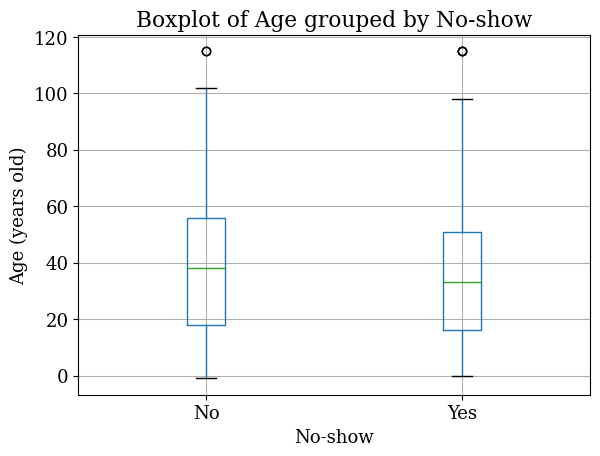

In [371]:
original_df[['Age','No-show']].boxplot(by='No-show')
plt.title("Boxplot of Age grouped by No-show")
plt.ylabel('Age (years old)')
plt.suptitle('')
plt.xlabel('No-show')
plt.savefig('Age.png', dpi=300,bbox_inches='tight')
plt.show()

In [20]:
original_df[original_df['Age']>110]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
63912,3.196321e+13,5700278,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
63915,3.196321e+13,5700279,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
68127,3.196321e+13,5562812,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,Yes
76284,3.196321e+13,5744037,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,115,ANDORINHAS,0,0,0,0,1,0,No
97666,7.482346e+14,5717451,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,115,SÃO JOSÉ,0,1,0,0,0,1,No


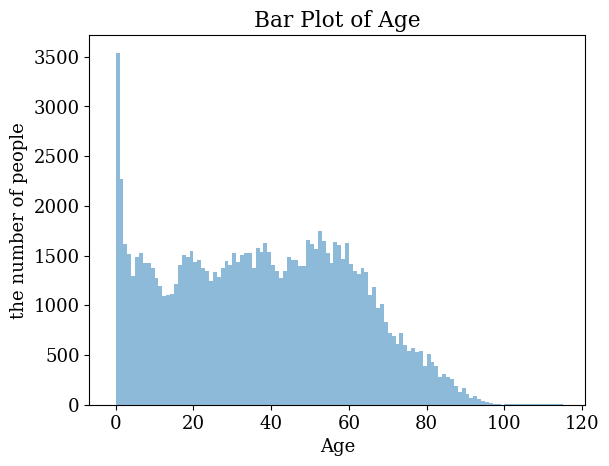

In [241]:
import matplotlib
from matplotlib import pylab as plt

bin_range = (original_df['Age'].min(),original_df['Age'].max())
plt.hist(original_df['Age'],alpha=0.5,range=bin_range,bins=np.unique(original_df['Age']))
plt.title("Bar Plot of Age")
plt.ylabel('the number of people')
plt.xlabel('Age')
plt.savefig('Age2.png', dpi=300)
plt.show()

In [23]:
print(original_df['Age'].value_counts().to_string())

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
 56     1635
 38     1629
 59     1624
 2      1618
 50     1613
 57     1603
 36     1580
 51     1567
 19     1545
 39     1536
 37     1533
 54     1530
 34     1526
 33     1524
 30     1521
 6      1521
 3      1513
 17     1509
 32     1505
 5      1489
 18     1487
 44     1487
 58     1469
 46     1460
 45     1453
 21     1452
 28     1448
 31     1439
 20     1437
 7      1427
 55     1425
 8      1424
 60     1411
 29     1403
 16     1402
 40     1402
 48     1399
 47     1394
 35     1378
 27     1377
 22     1376
 63     1374
 9      1372
 23     1349
 41     1346
 43     1344
 61     1343
 25     1332
 64     1331
 62     1312
 4      1299
 26     1283
 10     1274
 42     1272
 24     1242
 15     1211
 11     1195
 66     1187
 14     1118
 13     1103
 65     1101
 12     1092
 68     1012
 67      973
 69      832
 73      725
 70      724
 71      695
 72      615
 74      602
 76      571
 75      544

### Day of Week

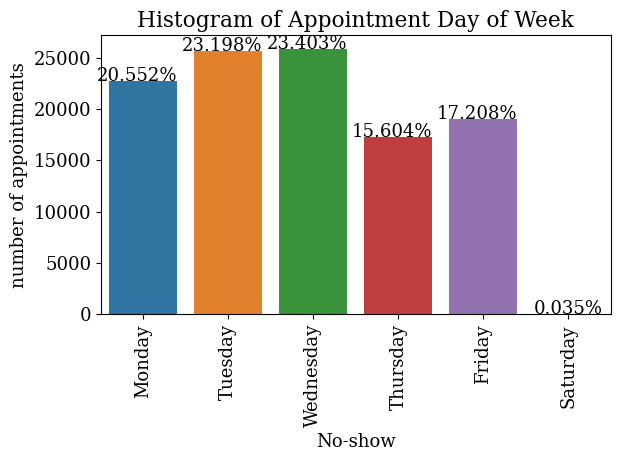

In [273]:
import seaborn

weekday = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')
weekday = weekday.dt.weekday
total = float(len(weekday))
ax=seaborn.countplot(x = weekday)
plt.xticks([0,1,2,3,4,5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title("Histogram of Appointment Day of Week")
for p in ax.patches:
    percentage = '{:.3f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='right')
plt.xlabel('No-show')
plt.xticks(rotation=90)
plt.ylabel('number of appointments')
plt.tight_layout()
plt.savefig('DayOfWeek.png', dpi=300)
plt.show()

# Preprocessing

## Neighbourhood, one-hot

In [27]:
print(len(original_df['Neighbourhood'].unique()))
original_df['Neighbourhood'].unique()

81


array(['JARDIM DA PENHA', 'MATA DA PRAIA', 'PONTAL DE CAMBURI',
       'REPÚBLICA', 'GOIABEIRAS', 'ANDORINHAS', 'CONQUISTA',
       'NOVA PALESTINA', 'DA PENHA', 'TABUAZEIRO', 'BENTO FERREIRA',
       'SÃO PEDRO', 'SANTA MARTHA', 'SÃO CRISTÓVÃO', 'MARUÍPE',
       'GRANDE VITÓRIA', 'SÃO BENEDITO', 'ILHA DAS CAIEIRAS',
       'SANTO ANDRÉ', 'SOLON BORGES', 'BONFIM', 'JARDIM CAMBURI',
       'MARIA ORTIZ', 'JABOUR', 'ANTÔNIO HONÓRIO', 'RESISTÊNCIA',
       'ILHA DE SANTA MARIA', 'JUCUTUQUARA', 'MONTE BELO',
       'MÁRIO CYPRESTE', 'SANTO ANTÔNIO', 'BELA VISTA', 'PRAIA DO SUÁ',
       'SANTA HELENA', 'ITARARÉ', 'INHANGUETÁ', 'UNIVERSITÁRIO',
       'SÃO JOSÉ', 'REDENÇÃO', 'SANTA CLARA', 'CENTRO', 'PARQUE MOSCOSO',
       'DO MOSCOSO', 'SANTOS DUMONT', 'CARATOÍRA', 'ARIOVALDO FAVALESSA',
       'ILHA DO FRADE', 'GURIGICA', 'JOANA D´ARC', 'CONSOLAÇÃO',
       'PRAIA DO CANTO', 'BOA VISTA', 'MORADA DE CAMBURI', 'SANTA LUÍZA',
       'SANTA LÚCIA', 'BARRO VERMELHO', 'ESTRELINHA', 'FORTE SÃO 

## Preprocess

In [29]:
df = pd.DataFrame()

# get target variable, no-show as 1
df['No-show'] = original_df['No-show'].apply(lambda s: 1 if s == 'No' else 0)

# create new data frame, and fix typo
df['Age'] = original_df['Age']
df['Gender'] = original_df['Gender'].apply(lambda g: 1 if g == 'M' else 0) # 0 as Female, 1 as male
df['Diabetes'] = original_df['Diabetes']
df['Alcoholism'] = original_df['Alcoholism']
df['Hypertension'] = original_df['Hipertension']
df['Handicap'] = original_df['Handcap']
df['Scholarship'] = original_df['Scholarship']
df['SMS_received'] = original_df['SMS_received']

# set weekday
df['AppointmentDay'] = pd.to_datetime(original_df['AppointmentDay']).dt.date.astype('datetime64[ns]')

df['AppointmentDayofWeek'] = df['AppointmentDay'].dt.weekday
df = df.drop(['AppointmentDay'],axis=1)

# one-hot neighbourhood

df['Neighbourhood'] = original_df['Neighbourhood']
factorize = pd.factorize(df['Neighbourhood'])
df['Neighbourhood'] = factorize[0]

df = df[df.Age >= 0]

In [30]:
df.shape

(110526, 11)

## Split

shuffle

In [31]:
X = df.loc[:, 'Age':]
y = df['No-show']

random_state = 42

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,
                    train_size = 0.6,random_state = random_state)
print('training set:',X_train.shape, y_train.shape) # 60% of points are in train
print(X_other.shape, y_other.shape) # 40% of points are in other

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,
                    train_size = 0.5,random_state = random_state)
print('validation set:',X_val.shape, y_val.shape) # 20% of points are in validation
print('test set:',X_test.shape, y_test.shape) # 20% of points are in test

print(X_train.head())


training set: (66315, 10) (66315,)
(44211, 10) (44211,)
validation set: (22105, 10) (22105,)
test set: (22106, 10) (22106,)
        Age  Gender  Diabetes  Alcoholism  Hypertension  Handicap  \
82166    37       1         0           0             0         0   
23506    57       1         1           0             0         0   
1791     25       0         0           0             0         0   
98784     4       1         0           0             0         0   
107427   54       0         0           0             0         0   

        Scholarship  SMS_received  AppointmentDayofWeek  Neighbourhood  
82166             0             0                     1             34  
23506             0             0                     1             72  
1791              0             0                     4             10  
98784             1             0                     4             44  
107427            0             0                     4             26  


## encoder

In [34]:
# apply OHE to the adult dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# let's collect all categorical features first
ordinal_ftrs = ['AppointmentDayofWeek','Handicap'] 
onehot_ftrs = ['Gender','Diabetes','Alcoholism','Hypertension','Scholarship','SMS_received','Neighbourhood']
minmax_ftrs = ['Age']
# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs)])
prep = Pipeline(steps=[('preprocessor', preprocessor)]) # for now we only preprocess 
                                                       # later on we will add other steps here

X_train_prep = prep.fit_transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)





print(X_train.shape)
print(X_train_prep.shape)
print(X_train_prep)

(66315, 10)
(66315, 96)
[[1.         0.         0.         ... 0.         0.         0.32173913]
 [1.         0.         0.         ... 0.         0.         0.49565217]
 [4.         0.         1.         ... 0.         0.         0.2173913 ]
 ...
 [2.         0.         0.         ... 0.         0.         0.52173913]
 [4.         0.         1.         ... 0.         0.         0.15652174]
 [2.         0.         0.         ... 0.         0.         0.07826087]]


In [35]:
X_train.head()

,Age,Gender,Diabetes,Alcoholism,Hypertension,Handicap,Scholarship,SMS_received,AppointmentDayofWeek,Neighbourhood
82166,37,1,0,0,0,0,0,0,1,34
23506,57,1,1,0,0,0,0,0,1,72
1791,25,0,0,0,0,0,0,0,4,10
98784,4,1,0,0,0,0,1,0,4,44
107427,54,0,0,0,0,0,0,0,4,26


# Model

## RF

In [40]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # decide which parameters to tune and what values to try
    # the default value of any parameter not specified here will be used
    param_grid = {
                  'max_depth': [1, 3, 10, 30, 100], # no upper bound so the values are evenly spaced in log
                  'max_features': [0.25, 0.5,0.75,1.0] # linearly spaced because it is between 0 and 1, 0 is omitted
                  } 

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = RandomForestClassifier(**params,random_state = 42*i,n_jobs=-1) # initialize the classifier
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


randoms state 1
    {'max_features': 0.25, 'max_depth': 1}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.5, 'max_depth': 1}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.75, 'max_depth': 1}
    0.7974213978737842 0.796516625197919
    {'max_features': 1.0, 'max_depth': 1}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.25, 'max_depth': 3}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.5, 'max_depth': 3}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.75, 'max_depth': 3}
    0.7974213978737842 0.796516625197919
    {'max_features': 1.0, 'max_depth': 3}
    0.7974213978737842 0.796516625197919
    {'max_features': 0.25, 'max_depth': 10}
    0.7983714091834426 0.7968332956344718
    {'max_features': 0.5, 'max_depth': 10}
    0.7992158636809168 0.7967428183668853
    {'max_features': 0.75, 'max_depth': 10}
    0.8004825454271282 0.7969690115358516
    {'max_features': 1.0, 'max_depth': 10}
    0.8013420794

    0.7996833295634472 0.8008595340420719
    {'max_features': 0.75, 'max_depth': 10}
    0.8004523863379326 0.8005881022393124
    {'max_features': 1.0, 'max_depth': 10}
    0.8008896931312675 0.8009500113096585
    {'max_features': 0.25, 'max_depth': 30}
    0.8424489180426751 0.7918570459172133
    {'max_features': 0.5, 'max_depth': 30}
    0.8496720199049989 0.7895498755937571
    {'max_features': 0.75, 'max_depth': 30}
    0.851617281158109 0.7884189097489256
    {'max_features': 1.0, 'max_depth': 30}
    0.8519791902284551 0.7889165347206515
    {'max_features': 0.25, 'max_depth': 100}
    0.9224760612229511 0.7530422981225967
    {'max_features': 0.5, 'max_depth': 100}
    0.9224911407675488 0.7531780140239764
    {'max_features': 0.75, 'max_depth': 100}
    0.9224911407675488 0.7523184799819046
    {'max_features': 1.0, 'max_depth': 100}
    0.9224760612229511 0.7516399004750056
best model parameters: {'max_features': 0.25, 'max_depth': 1}
corresponding validation score: 0.8014

In [43]:
test_scores_rf = test_scores
final_models_rf = final_models

## KNN

In [44]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    # loop through the different random states
    for i in range(nr_states):
        print('randoms state '+str(i+1))

        # first split to separate out the training set
        X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

        # second split to separate out the validation and test sets
        X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)

        # preprocess the sets
        X_train_prep = prep.fit_transform(X_train)
        X_val_prep = prep.transform(X_val)
        X_test_prep = prep.transform(X_test)

        # decide which parameters to tune and what values to try
        # the default value of any parameter not specified here will be used
        param_grid = {
                      'n_neighbors': [1,2,5,10,50],
                      'weights' : ['uniform','distance']
                      } 

        # we save the train and validation scores
        # the validation scores are necessary to select the best model
        # it's optional to save the train scores, it can be used to identify high bias and high variance models
        train_score = np.zeros(len(ParameterGrid(param_grid)))
        val_score = np.zeros(len(ParameterGrid(param_grid)))
        models = []

        # loop through all combinations of hyperparameter combos
        for p in range(len(ParameterGrid(param_grid))):
            params = ParameterGrid(param_grid)[p]
            print('   ',params) 
            clf = KNeighborsClassifier(**params,n_jobs=-1) # initialize the classifier
            clf.fit(X_train_prep,y_train) # fit the model
            models.append(clf) # save it
            # calculate train and validation accuracy scores
            y_train_pred = clf.predict(X_train_prep)
            train_score[p] = accuracy_score(y_train,y_train_pred)
            y_val_pred = clf.predict(X_val_prep)
            val_score[p] = accuracy_score(y_val,y_val_pred)
            print('   ',train_score[p],val_score[p])

        # print out model parameters that maximize validation accuracy
        print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
        print('corresponding validation score:',np.max(val_score))
        # collect and save the best model
        final_models.append(models[np.argmax(val_score)])
        # calculate and save the test score
        y_test_pred = final_models[-1].predict(X_test_prep)
        test_scores[i] = accuracy_score(y_test,y_test_pred)
        print('test score:',test_scores[i])


randoms state 1
    {'weights': 'uniform', 'n_neighbors': 1}
    0.9063861871371485 0.6982583125989595
    {'weights': 'distance', 'n_neighbors': 1}
    0.9063861871371485 0.6982583125989595
    {'weights': 'uniform', 'n_neighbors': 2}
    0.8186684762120184 0.6204026238407601
    {'weights': 'distance', 'n_neighbors': 2}
    0.8956344718389505 0.66731508708437
    {'weights': 'uniform', 'n_neighbors': 5}
    0.8217748623991555 0.7645781497398778
    {'weights': 'distance', 'n_neighbors': 5}
    0.9214054135565106 0.7217824021714544
    {'weights': 'uniform', 'n_neighbors': 10}
    0.8051421247078339 0.7714091834426601
    {'weights': 'distance', 'n_neighbors': 10}
    0.9218427203498454 0.7297444017190681
    {'weights': 'uniform', 'n_neighbors': 50}
    0.7980698182914876 0.7967428183668853
    {'weights': 'distance', 'n_neighbors': 50}
    0.9218427203498454 0.7416421624066953
best model parameters: {'weights': 'uniform', 'n_neighbors': 50}
corresponding validation score: 0.79674281

In [45]:
test_scores_knn = test_scores
final_models_knn = final_models

## Logistic Regression

### Elastic Net

In [46]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # decide which parameters to tune and what values to try
    # the default value of any parameter not specified here will be used
    param_grid = {
                  'l1_ratio': [0.1,0.3,0.5,0.7,0.9] # no upper bound so the values are evenly spaced in log
                  } 

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = LogisticRegression(**params,random_state = 42*i,max_iter=1000,penalty='elasticnet',solver='saga') # initialize the classifier
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


randoms state 1
    {'l1_ratio': 0.1}
    0.797436477418382 0.7965618638317122
    {'l1_ratio': 0.3}
    0.797436477418382 0.7965618638317122
    {'l1_ratio': 0.5}
    0.797436477418382 0.7965618638317122
    {'l1_ratio': 0.7}
    0.797436477418382 0.7965618638317122
    {'l1_ratio': 0.9}
    0.797436477418382 0.7965618638317122
best model parameters: {'l1_ratio': 0.1}
corresponding validation score: 0.7965618638317122
test score: 0.8015018547000814
randoms state 2
    {'l1_ratio': 0.1}
    0.79657694337631 0.7987333182537887
    {'l1_ratio': 0.3}
    0.79657694337631 0.7987333182537887
    {'l1_ratio': 0.5}
    0.79657694337631 0.7987333182537887
    {'l1_ratio': 0.7}
    0.79657694337631 0.7987333182537887
    {'l1_ratio': 0.9}
    0.79657694337631 0.7987333182537887
best model parameters: {'l1_ratio': 0.1}
corresponding validation score: 0.7987333182537887
test score: 0.8018637473988962
randoms state 3
    {'l1_ratio': 0.1}
    0.7986730000753978 0.7966975797330921
    {'l1_ratio': 

In [47]:
test_scores_en = test_scores
final_models_en = final_models

### Lasso

In [135]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # decide which parameters to tune and what values to try
    # the default value of any parameter not specified here will be used
    param_grid = {
                  'C': np.logspace(-5,5,10) # no upper bound so the values are evenly spaced in log
                  } 

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = LogisticRegression(**params,random_state = 42*i,max_iter=5000,penalty='l1',solver='saga') # initialize the classifier
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


randoms state 1
    {'C': 1e-05}
    0.7974213978737842 0.796516625197919
    {'C': 0.0001291549665014884}
    0.7974213978737842 0.796516625197919
    {'C': 0.0016681005372000592}
    0.7974213978737842 0.796516625197919
    {'C': 0.021544346900318846}
    0.7974213978737842 0.796516625197919
    {'C': 0.2782559402207126}
    0.7974213978737842 0.7965618638317122
    {'C': 3.593813663804626}
    0.7974213978737842 0.7966071024655056
    {'C': 46.41588833612782}
    0.7974213978737842 0.7966071024655056
    {'C': 599.4842503189421}
    0.7974213978737842 0.7966071024655056
    {'C': 7742.636826811277}
    0.7974213978737842 0.7966071024655056
    {'C': 100000.0}
    0.7974213978737842 0.7966071024655056
best model parameters: {'C': 3.593813663804626}
corresponding validation score: 0.7966071024655056
test score: 0.8015470912874333
randoms state 2
    {'C': 1e-05}
    0.79657694337631 0.7987333182537887
    {'C': 0.0001291549665014884}
    0.79657694337631 0.7987333182537887
    {'C': 0

In [144]:
test_scores_lasso = test_scores
final_models_lasso = final_models

### Ridge

In [146]:
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)

    # decide which parameters to tune and what values to try
    # the default value of any parameter not specified here will be used
    param_grid = {
                  'C': np.logspace(-5,5,10) # no upper bound so the values are evenly spaced in log
                  } 

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = LogisticRegression(**params,random_state = 42*i,max_iter=5000,penalty='l2',solver='saga') # initialize the classifier
        clf.fit(X_train_prep,y_train) # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


randoms state 1
    {'C': 1e-05}
    0.7974213978737842 0.796516625197919
    {'C': 0.0001291549665014884}
    0.7974213978737842 0.796516625197919
    {'C': 0.0016681005372000592}
    0.7974213978737842 0.796516625197919
    {'C': 0.021544346900318846}
    0.7974213978737842 0.796516625197919
    {'C': 0.2782559402207126}
    0.7974213978737842 0.7965618638317122
    {'C': 3.593813663804626}
    0.7974213978737842 0.7965618638317122
    {'C': 46.41588833612782}
    0.7974213978737842 0.7966071024655056
    {'C': 599.4842503189421}
    0.7974213978737842 0.7966071024655056
    {'C': 7742.636826811277}
    0.7974213978737842 0.7966071024655056
    {'C': 100000.0}
    0.7974213978737842 0.7966071024655056
best model parameters: {'C': 46.41588833612782}
corresponding validation score: 0.7966071024655056
test score: 0.8015923278747851
randoms state 2
    {'C': 1e-05}
    0.79657694337631 0.7987333182537887
    {'C': 0.0001291549665014884}
    0.79657694337631 0.7987333182537887
    {'C': 0

In [148]:
test_scores_ridge = test_scores
final_models_ridge = final_models

## XGBoost

In [398]:
import xgboost
nr_states = 5
test_scores = np.zeros(nr_states)
final_models = []

test_sets = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    # first split to separate out the training set
    X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*i)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*i)
    
    # preprocess the sets
    X_train_prep = prep.fit_transform(X_train)
    X_val_prep = prep.transform(X_val)
    X_test_prep = prep.transform(X_test)
    
    test_sets.append([X_test_prep,y_test])

    # decide which parameters to tune and what values to try
    # the default value of any parameter not specified here will be used
    param_grid = {"learning_rate": [0.01],
              "n_estimators": [200],
              "seed": [0],
#               "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
#               "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
#               "max_depth": [1,3,10,30,100],
              "max_depth": [1,2,6,10],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]
             }

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    # it's optional to save the train scores, it can be used to identify high bias and high variance models
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []
    
    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print('   ',params) 
        clf = xgboost.XGBClassifier(use_label_encoder=False)
        clf.set_params(**params,random_state = 42*i,n_jobs=-1) 
        clf.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)], 
                    verbose=False,eval_metric = 'logloss') # fit the model
        models.append(clf) # save it
        # calculate train and validation accuracy scores
        y_train_pred = clf.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train,y_train_pred)
        y_val_pred = clf.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val,y_val_pred)
        print('   ',train_score[p],val_score[p])
    
    # print out model parameters that maximize validation accuracy
    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_models.append(models[np.argmax(val_score)])
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])


randoms state 1
    {'subsample': 0.66, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 1, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
    0.7974213978737842 0.796516625197919
    {'subsample': 0.66, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 2, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
    0.7974213978737842 0.796516625197919
    {'subsample': 0.66, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
    0.797738068310337 0.7966975797330921
    {'subsample': 0.66, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
    0.799879363643218 0.7974666365075774
best model parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 200, 'missing': nan, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
corresponding validation score: 0.7974666365075774
test score: 0.8014566181127296
randoms state 2
    {'subsample': 0.6

In [380]:
test_scores_xgboost = test_scores
final_models_xgboost = final_models

# Result

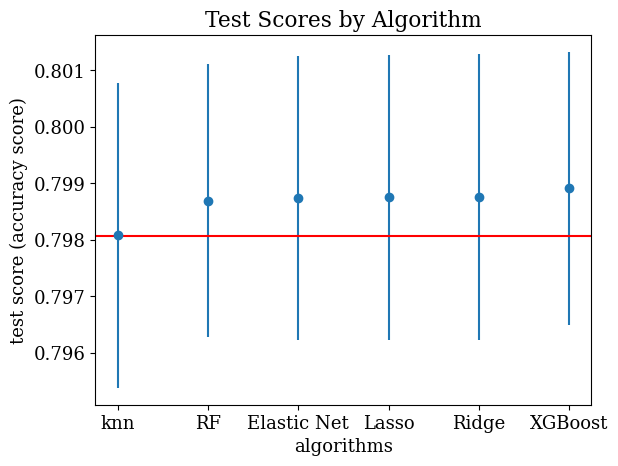

In [381]:
models= ["knn", "RF", "Elastic Net", "Lasso", "Ridge", "XGBoost"]

tmp = [test_scores_knn, test_scores_rf,test_scores_en,test_scores_lasso,test_scores_ridge,test_scores_xgboost]
means = [np.mean(i) for i in tmp]
stds = [np.std(i) for i in tmp]

bl = sum(original_df['No-show'] == 'No')/original_df.shape[0]
plt.title("Test Scores by Algorithm")
plt.errorbar(models,means,yerr=stds,label = "test scores", fmt = "o")
plt.axhline(y=bl, color='r', linestyle='-')
plt.xlabel("algorithms")
plt.ylabel("test score (accuracy score)")
plt.savefig('testscores.png', dpi=300, bbox_inches='tight')
plt.show()

In [382]:
bl

0.798067440534892

In [417]:
means

[0.7980819686962816,
 0.7986971862842667,
 0.7987424228716186,
 0.798751470189089,
 0.7987605175065593,
 0.7989143219035555]

In [418]:
stds

[0.002702196100926488,
 0.0024170057208967363,
 0.002508897968671306,
 0.0025188940717300093,
 0.002528980131123477,
 0.002414532248210798]

In [440]:
for i in range(len(means)):
    print((means[i] - bl) / stds[i])

0.005376427485999562
0.26054789359002656
0.26903538731152443
0.2715595156914258
0.27405394100879055
0.3507434490846254


## Permutation

In [376]:
test_scores_xgboost

array([0.80145662, 0.80186375, 0.79810911, 0.79765674, 0.79548539])

In [385]:
test_scores_xgboost[0]

0.8014566181127296

In [420]:
final_models_xgboost[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.66, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [422]:
from xgboost import XGBClassifier

# first split to separate out the training set
X_train, X_other, y_train, y_other = train_test_split(X,y,train_size = 0.6,random_state=42*0)

# second split to separate out the validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=42*0)

X_train_prep = prep.fit_transform(X_train)
X_val_prep = prep.transform(X_val)
X_test_prep = prep.transform(X_test)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')

    clf_XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=np.nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.66, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None, eval_metric = 'logloss')
    clf_XGB.fit(X_train_prep, y_train)

print('Train score: {}'.format(clf_XGB.score(X_train_prep, y_train)))
print('Test score: {}'.format(clf_XGB.score(X_test_prep, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, clf_XGB.predict(X_test_prep))))
print('f1 score: {:.3f}'.format(f1_score(y_test, clf_XGB.predict(X_test_prep))))

Train score: 0.799879363643218
Test score: 0.8014566181127296
Confusion matrix:
[[   30  4357]
 [   32 17687]]
f1 score: 0.890


In [423]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf_XGB, X_test_prep, y_test, 
                                n_repeats=10, 
                                random_state=0)
importance_scores = result.importances
print("the perturbation feature importance values on the test set are " +  str(importance_scores))

the perturbation feature importance values on the test set are [[-1.35709762e-04 -2.71419524e-04  2.26182937e-04  1.80946349e-04
   2.26182937e-04  2.71419524e-04  2.71419524e-04  5.88075636e-04
  -2.26182937e-04  2.71419524e-04]
 [ 9.04731747e-05  4.52365874e-05  9.04731747e-05  1.35709762e-04
   9.04731747e-05  9.04731747e-05  9.04731747e-05  4.52365874e-05
   9.04731747e-05  9.04731747e-05]
 [ 0.00000000e+00 -4.52365874e-05  4.07129286e-04 -9.04731747e-05
   9.04731747e-05  0.00000000e+00  0.00000000e+00  1.35709762e-04
   2.26182937e-04 -4.52365874e-05]
 [ 9.04731747e-05  0.00000000e+00  4.52365874e-05  9.04731747e-05
   9.04731747e-05  9.04731747e-05  1.80946349e-04  4.52365874e-05
   9.04731747e-05  9.04731747e-05]
 [ 9.04731747e-05 -9.04731747e-05  0.00000000e+00  1.80946349e-04
   4.52365874e-05  9.04731747e-05  4.52365874e-05  4.52365874e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.52365874e-05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0

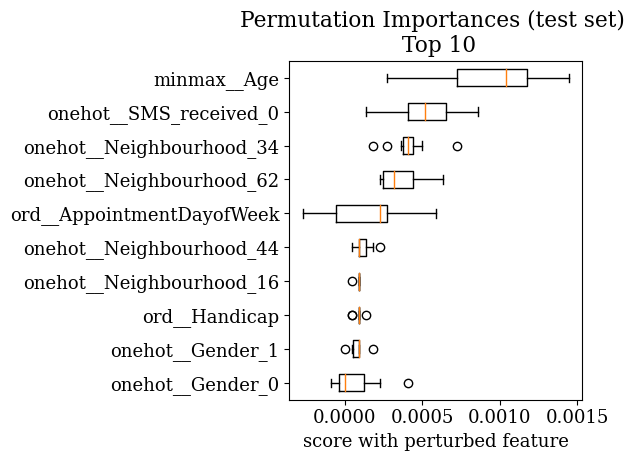

In [424]:
import matplotlib.pylab as plt
ftr_names = preprocessor.get_feature_names_out()
test_score = np.sqrt(mean_squared_error(y_test,y_test_pred))

sorted_indcs = np.argsort(np.mean(importance_scores,axis=1))
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(importance_scores[sorted_indcs[-10:]].T,labels=ftr_names[sorted_indcs[-10:]],vert=False)
# plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set) \n Top 10")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.savefig('perm_top.png', dpi=300)
plt.show()

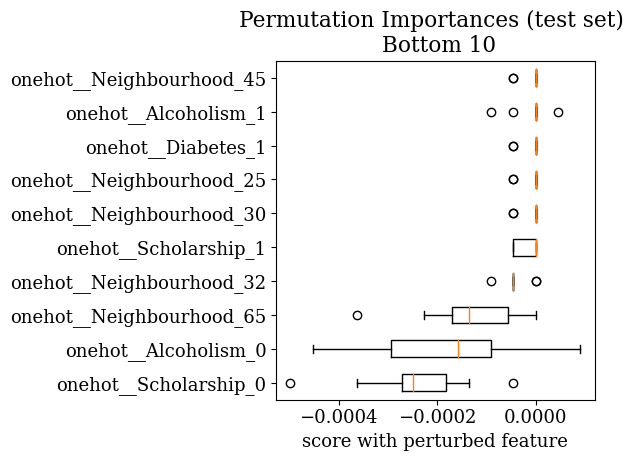

In [425]:
import matplotlib.pylab as plt
ftr_names = preprocessor.get_feature_names_out()
test_score = np.sqrt(mean_squared_error(y_test,y_test_pred))

sorted_indcs = np.argsort(np.mean(importance_scores,axis=1))
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(6.4,4.8))
plt.boxplot(importance_scores[sorted_indcs[0:10]].T,labels=ftr_names[sorted_indcs[0:10]],vert=False)
# plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set) \n Bottom 10")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.savefig('perm_bot.png', dpi=300)
plt.show()

## Weight

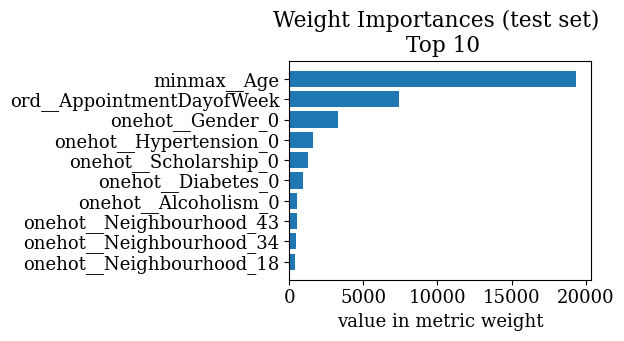

In [426]:
metric = 'weight'
scores = clf_XGB.get_booster().get_score(importance_type=metric)
scores_ = {}
for k,v in scores.items():
    idx = int(k[1:])
    scores_[ftr_names[idx]] = v
scores_ = dict(sorted(scores_.items(), key=lambda item: item[1]))
feature_names_tmp = list(scores_.keys())[-10:]
summary = list(scores_.values())[-10:]
plt.figure(figsize=(6.4,3.6))
plt.barh(feature_names_tmp,summary)
plt.title("Weight Importances (test set) \n Top 10")
plt.xlabel('value in metric ' +  metric)
plt.tight_layout()
plt.savefig('weight_top.png', dpi=300)

plt.show()

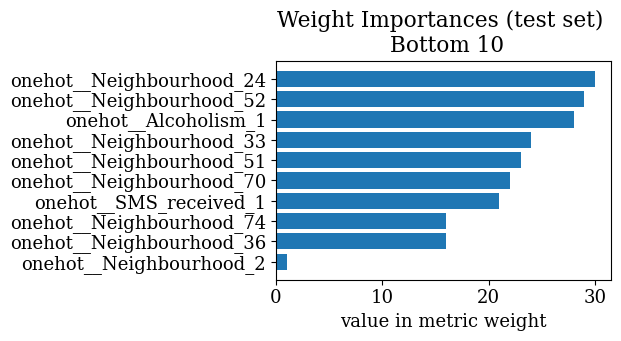

In [427]:
metric = 'weight'
scores = clf_XGB.get_booster().get_score(importance_type=metric)
scores_ = {}
for k,v in scores.items():
    idx = int(k[1:])
    scores_[ftr_names[idx]] = v
scores_ = dict(sorted(scores_.items(), key=lambda item: item[1]))
feature_names_tmp = list(scores_.keys())[0:10]
summary = list(scores_.values())[0:10]
plt.figure(figsize=(6.4,3.6))
plt.barh(feature_names_tmp,summary)
plt.title("Weight Importances (test set) \n Bottom 10")
plt.xlabel('value in metric ' +  metric)
plt.tight_layout()
plt.savefig('weight_bot.png', dpi=300)
plt.show()

## gain

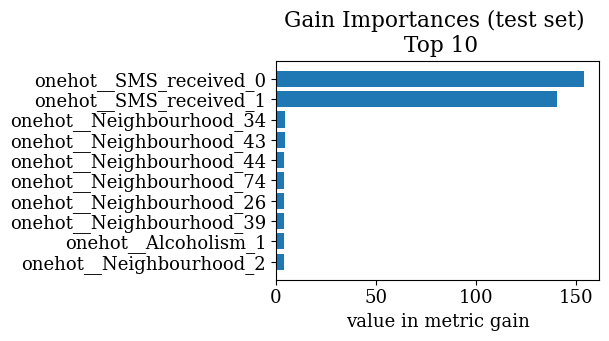

In [428]:
metric = 'gain'
scores = clf_XGB.get_booster().get_score(importance_type=metric)
scores_ = {}
for k,v in scores.items():
    idx = int(k[1:])
    scores_[ftr_names[idx]] = v
scores_ = dict(sorted(scores_.items(), key=lambda item: item[1]))
feature_names_tmp = list(scores_.keys())[-10:]
summary = list(scores_.values())[-10:]
plt.figure(figsize=(6.4,3.6))
plt.barh(feature_names_tmp,summary)
plt.title("Gain Importances (test set) \n Top 10")
plt.xlabel('value in metric ' +  metric)
plt.tight_layout()
plt.savefig('gain_top.png', dpi=300)
plt.show()

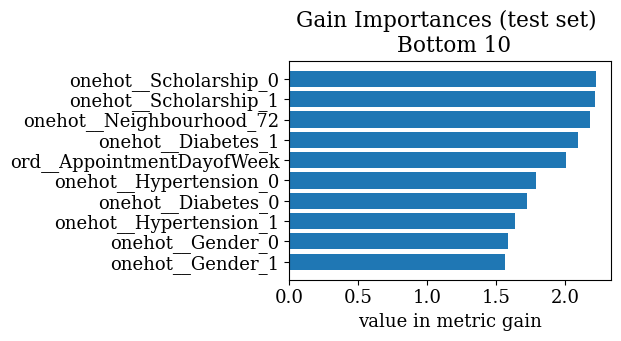

In [429]:
metric = 'gain'
scores = clf_XGB.get_booster().get_score(importance_type=metric)
scores_ = {}
for k,v in scores.items():
    idx = int(k[1:])
    scores_[ftr_names[idx]] = v
scores_ = dict(sorted(scores_.items(), key=lambda item: item[1]))
feature_names_tmp = list(scores_.keys())[0:10]
summary = list(scores_.values())[0:10]
plt.figure(figsize=(6.4,3.6))
plt.barh(feature_names_tmp,summary)
plt.title("Gain Importances (test set) \n Bottom 10")
plt.xlabel('value in metric ' +  metric)
plt.tight_layout()
plt.savefig('gain_bot.png', dpi=300)
plt.show()

## SHAP

(22106, 96)


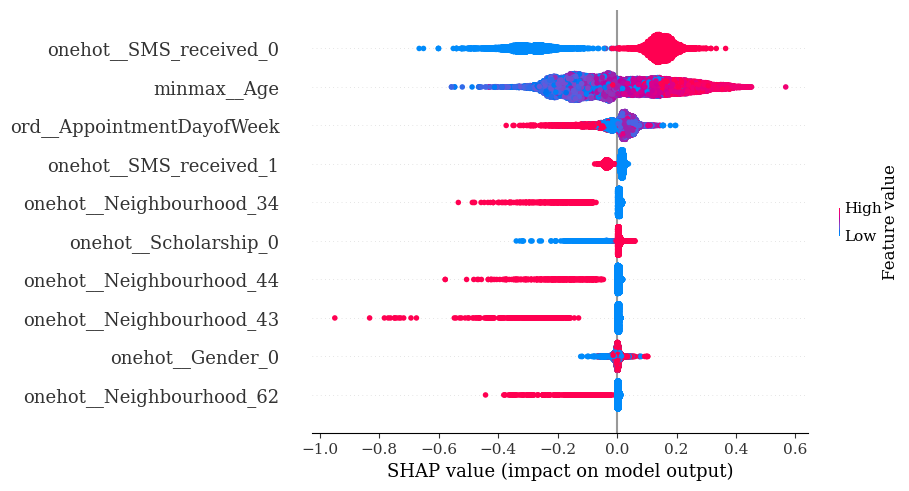

In [430]:
import shap
import warnings
shap.initjs() # required for visualizations later on
# create the explainer object with the XGBoost model
explainer = shap.TreeExplainer(clf_XGB)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    shap_values = explainer.shap_values(X_test_prep)
print(np.shape(shap_values))
shap.summary_plot(shap_values, X_test_prep, feature_names = ftr_names, max_display=10)

In [431]:
# save figs
import shap
import warnings
shap.initjs() # required for visualizations later on
# create the explainer object with the XGBoost model
explainer = shap.TreeExplainer(clf_XGB)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    shap_values = explainer.shap_values(X_test_prep)
print(np.shape(shap_values))
shap.summary_plot(shap_values, X_test_prep, feature_names = ftr_names, max_display=10,show=False)
plt.savefig('shap.png', format='png', dpi=300, bbox_inches='tight')

(22106, 96)


(22106, 96)


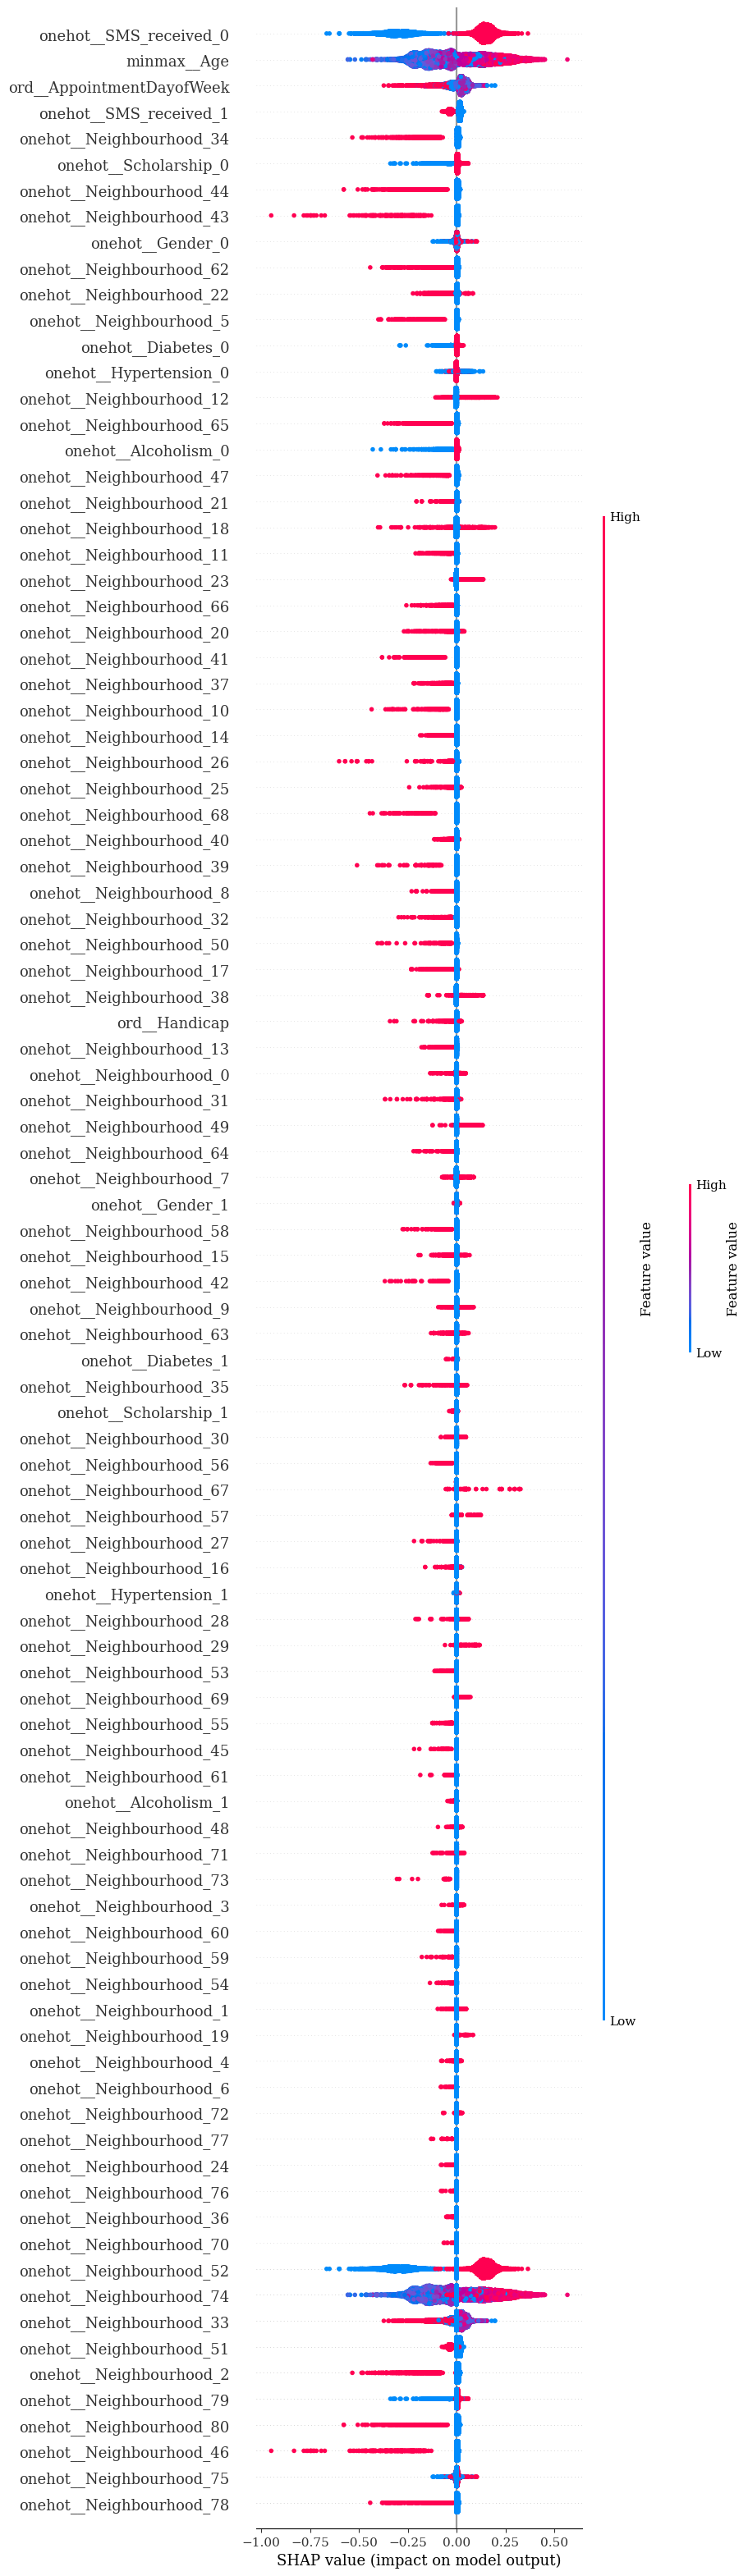

In [432]:
import shap
import warnings
shap.initjs() # required for visualizations later on
# create the explainer object with the XGBoost model
explainer = shap.TreeExplainer(clf_XGB)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    shap_values = explainer.shap_values(X_test_prep)
print(np.shape(shap_values))
shap.summary_plot(shap_values, X_test_prep, feature_names = ftr_names, max_display=100)

In [433]:
# save figs
import shap
import warnings
shap.initjs() # required for visualizations later on
# create the explainer object with the XGBoost model
explainer = shap.TreeExplainer(clf_XGB)

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore')
    shap_values = explainer.shap_values(X_test_prep)
print(np.shape(shap_values))
shap.summary_plot(shap_values, X_test_prep, feature_names = ftr_names, max_display=100,show=False)
plt.savefig('shap1.png', format='png', dpi=300, bbox_inches='tight')

(22106, 96)


1.1453097


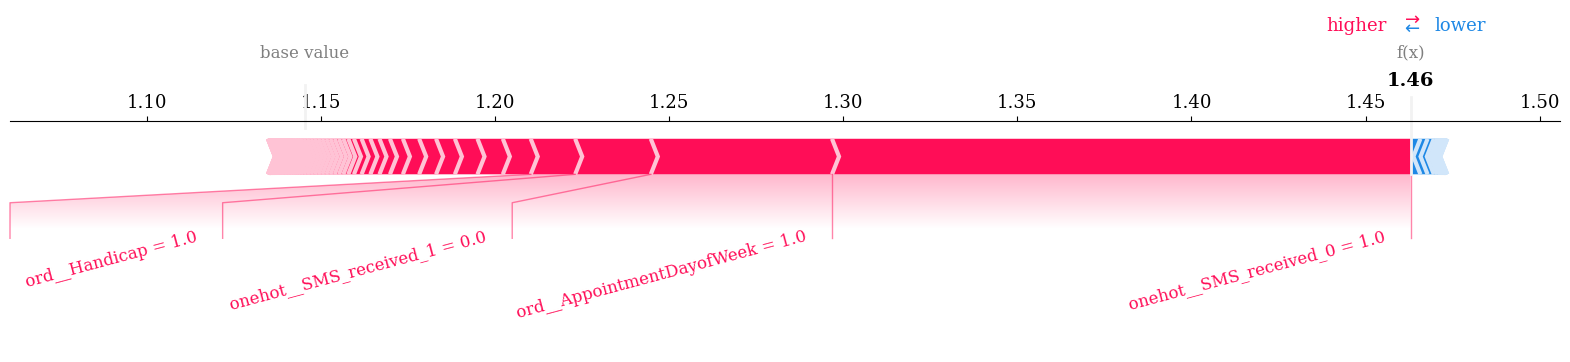

In [437]:
index = 0 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features = X_test_prep[index,:],
                feature_names = ftr_names,matplotlib=True,text_rotation=15,show=False)
plt.savefig('i0.png', dpi=300)
plt.show()

1.1453097


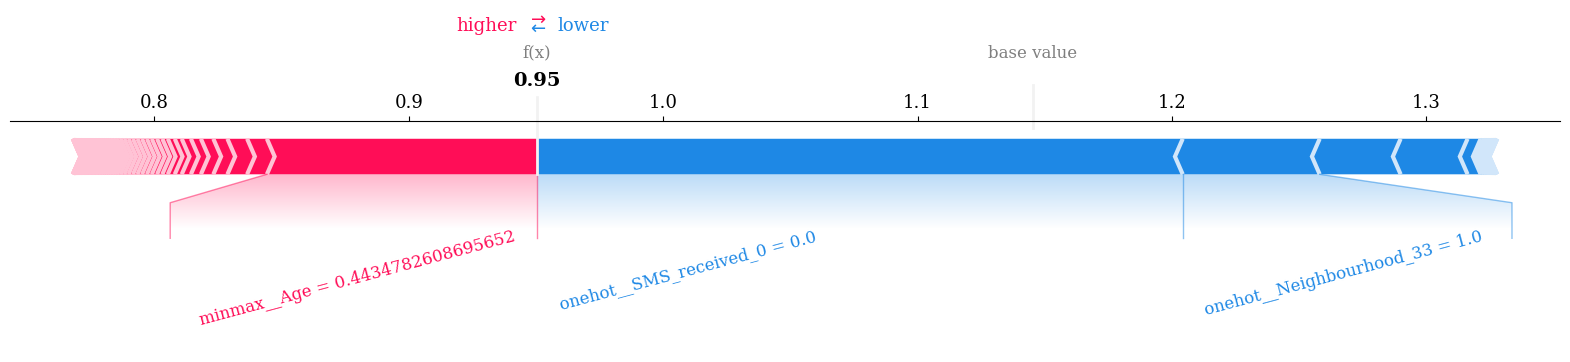

In [435]:
index = 5000 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features = X_test_prep[index,:],
                feature_names = ftr_names,matplotlib=True,text_rotation=15,show=False)
plt.savefig('i5000.png', dpi=300)
plt.show()

1.1453097


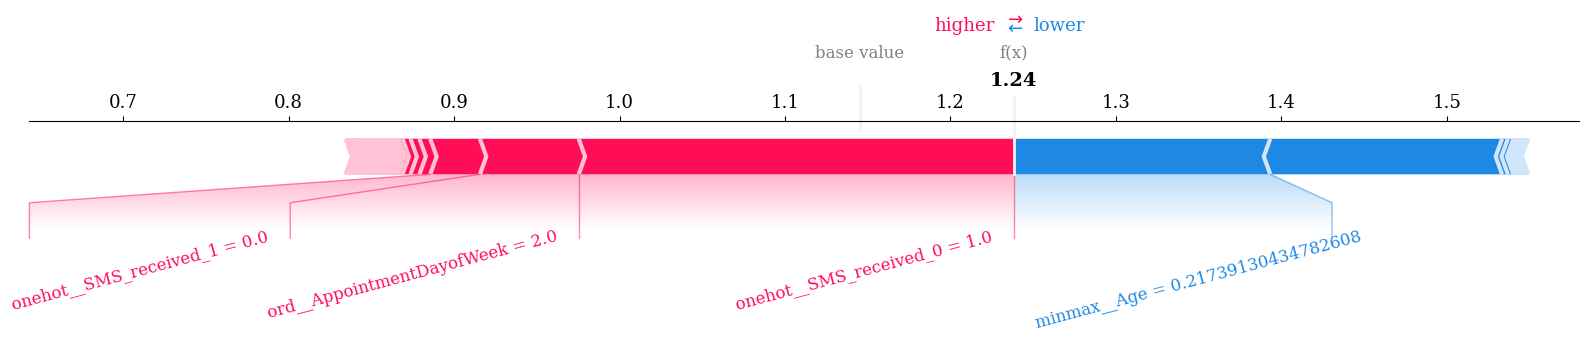

In [436]:
index = 15000 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                features = X_test_prep[index,:],
                feature_names = ftr_names,matplotlib=True,text_rotation=15,show=False)
plt.savefig('i15000.png', dpi=300)
plt.show()

## Confusion Matrix

In [399]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, fbeta_score, accuracy_score
import warnings

df1 = pd.DataFrame()
y_true = pd.DataFrame()
y_pred = pd.DataFrame()


with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    for i in range(5):
        cur = pd.DataFrame(data=test_sets[i][0],columns = preprocessor.get_feature_names_out())
        df1 = pd.concat([df1,cur],ignore_index=True)
        y_true = pd.concat([y_true,test_sets[i][1]],ignore_index=True)
        cur_pred = final_models[i].predict(cur)
        cur_pred = pd.Series(cur_pred)
        y_pred = pd.concat([y_pred,cur_pred],ignore_index=True)

In [400]:
print(df1.columns)

Index(['ord__AppointmentDayofWeek', 'ord__Handicap', 'onehot__Gender_0',
       'onehot__Gender_1', 'onehot__Diabetes_0', 'onehot__Diabetes_1',
       'onehot__Alcoholism_0', 'onehot__Alcoholism_1',
       'onehot__Hypertension_0', 'onehot__Hypertension_1',
       'onehot__Scholarship_0', 'onehot__Scholarship_1',
       'onehot__SMS_received_0', 'onehot__SMS_received_1',
       'onehot__Neighbourhood_0', 'onehot__Neighbourhood_1',
       'onehot__Neighbourhood_2', 'onehot__Neighbourhood_3',
       'onehot__Neighbourhood_4', 'onehot__Neighbourhood_5',
       'onehot__Neighbourhood_6', 'onehot__Neighbourhood_7',
       'onehot__Neighbourhood_8', 'onehot__Neighbourhood_9',
       'onehot__Neighbourhood_10', 'onehot__Neighbourhood_11',
       'onehot__Neighbourhood_12', 'onehot__Neighbourhood_13',
       'onehot__Neighbourhood_14', 'onehot__Neighbourhood_15',
       'onehot__Neighbourhood_16', 'onehot__Neighbourhood_17',
       'onehot__Neighbourhood_18', 'onehot__Neighbourhood_19',
      

In [401]:
df1['y_pred'] = y_pred
df1['y_true'] = y_true

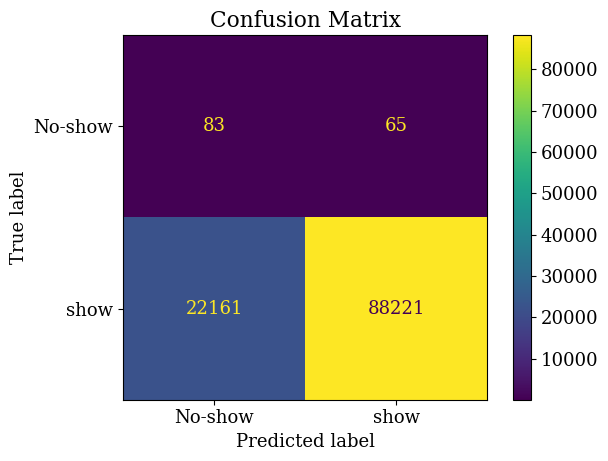

accuracy is 0.7989143219035556


In [403]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

tmp = df1
y_true_tmp, y_pred_tmp = tmp['y_pred'], tmp['y_true'] 
cm = confusion_matrix(y_true_tmp, y_pred_tmp)
disp = ConfusionMatrixDisplay(cm,display_labels=['No-show', 'show'])
disp.plot()
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('cm2.png', dpi=300)
plt.show()
print("accuracy is", accuracy_score(y_true_tmp, y_pred_tmp))


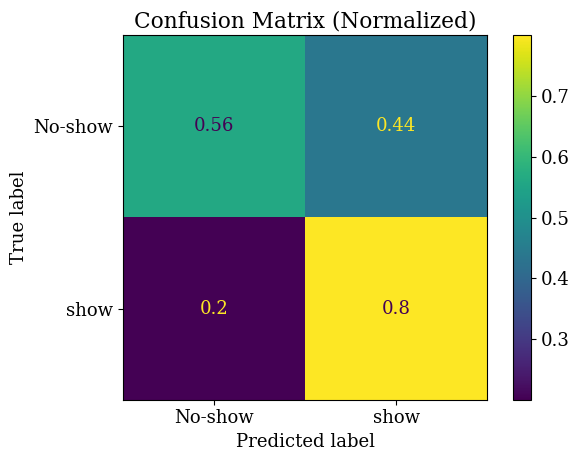

accuracy is 0.7989143219035556


In [405]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

tmp = df1
y_true_tmp, y_pred_tmp = tmp['y_pred'], tmp['y_true'] 
cm = confusion_matrix(y_true_tmp, y_pred_tmp, normalize='true')
disp = ConfusionMatrixDisplay(cm,display_labels=['No-show', 'show'])
disp.plot()
plt.title('Confusion Matrix (Normalized)')
plt.tight_layout()
plt.savefig('cm1.png', dpi=300)
plt.show()
print("accuracy is", accuracy_score(y_true_tmp, y_pred_tmp))


In [438]:
recall = 83/(83+22161)
precision = 83/(83+65)
f1 = (2 * precision * recall) / (precision + recall)
f2 = (5 * precision * recall) / (4 * precision + recall)
f0_5 = (1.25 * precision * recall) / (0.25 * precision + recall)
print('recall is', recall)
print('precision is', precision)
print('f0.5 score is', f0_5)
print('f1 score is', f1)
print('f2 score is', f2)

recall is 0.0037313432835820895
precision is 0.5608108108108109
f0.5 score is 0.01817306008057453
f1 score is 0.007413361914969632
f2 score is 0.004656433732776805


## Save Models & test scores & predictions

In [407]:
import joblib

joblib.dump(final_models_xgboost1, "xgboost.joblib", compress=3)
joblib.dump(final_models_knn, "knn.joblib", compress=3)
joblib.dump(final_models_rf, "random_forest.joblib", compress=3)
joblib.dump(final_models_en, "elastic_net.joblib", compress=3)
joblib.dump(final_models_lasso, "lasso.joblib", compress=3)
joblib.dump(final_models_ridge, "ridge.joblib", compress=3)

['ridge.joblib']

In [408]:
df_test_scores = pd.DataFrame(list(zip(test_scores_xgboost1, test_scores_knn, test_scores_rf, 
                                  test_scores_en, test_scores_lasso, test_scores_ridge)),
               columns =['XGBoost', 'KNN', 'Random Forest', 'Elastic Net', 'Lasso', 'Ridge'])
df_test_scores.to_csv('test_scores.csv', index = False)

In [409]:
df_xbg_pred = pd.concat([y_true, y_pred], axis=1)
df_xbg_pred.columns = ['y_true', 'y_pred']
df_xbg_pred.to_csv('xgboost_pred.csv', index = False)